In [ ]:
import numpy as np

# Параметры
VA = 10
eta = 0.6
xi = 0.1 * 0.4  # ξ = 0.1*N0, где N0 = 0.4
Vel = 0.01 * 0.4  # Vel = 0.01*N0
N0 = 0.4
L = 30  # км
alpha = 0.2  # дБ/км
T = 10**(-alpha * L / 10)
ILO = 10**7  # Мощность LO

# Коэффициенты аттенюации
r1 = 1
r2 = 0.001

# Генерация данных
num_samples = 1 * 10 ** 7  # Количество импульсов

# Функция для генерации данных для определенного коэффициента аттенюации
def generate_data(ri, num_samples):
    y = np.random.normal(0, np.sqrt(ri*eta*T*VA + ri*eta*xi + N0 + Vel), num_samples)
    return y

# Генерация данных для обоих коэффициентов аттенюации
data_r1 = generate_data(r1, int(num_samples * 0.9))
data_r2 = generate_data(r2, int(num_samples * 0.1))

# Объединение данных
data_normal = np.concatenate([data_r1, data_r2])


In [ ]:
k = 0.95  # Коэффициент ослабления локального осциллятора

def generate_LOIA_data(ri, num_samples, k):
    xi_Gau = (1 - eta*T) * (N0 - 1) / (eta*T)  # Дополнительный шум от атаки
    V_LOIA = k * (ri*eta*T*(VA*N0 + xi + xi_Gau) + N0 + Vel)  # Измененная дисперсия
    y_LOIA = np.random.normal(0, np.sqrt(V_LOIA), num_samples)
    return y_LOIA

# Генерация данных для атаки LO
data_LOIA_r1 = generate_LOIA_data(r1, int(num_samples * 0.9), k)
data_LOIA_r2 = generate_LOIA_data(r2, int(num_samples * 0.1), k)

# Объединение данных для атаки LO
data_LOIA = np.concatenate([data_LOIA_r1, data_LOIA_r2])


In [ ]:
# Коэффициент ослабления для калибровочной атаки
delta = 1 / (1 + 2.1 * eta * T)
mu = 1

def generate_calibration_data(ri, num_samples, delta):
    N_calib = N0 * delta  # Модифицированный шум детектора после атаки
    xi_calib = (xi + 2*mu*N0) / delta - 1 - Vel / (eta*T)  # Избыточный шум после атаки
    V_calib = ri * eta * T * (VA * N_calib + xi_calib + 2*N_calib) + N_calib + Vel * N_calib  # Измененная дисперсия
    y_calib = np.random.normal(0, np.sqrt(V_calib), num_samples)
    return y_calib

# Генерация данных для калибровочной атаки
data_calib_r1 = generate_calibration_data(r1, int(num_samples * 0.9), delta)
data_calib_r2 = generate_calibration_data(r2, int(num_samples * 0.1), delta)

# Объединение данных для калибровочной атаки
data_calib = np.concatenate([data_calib_r1, data_calib_r2])


In [ ]:
from scipy.special import erf

alpha = 20 * np.sqrt(N0)  # Граница линейного диапазона
Delta = 19.5 * np.sqrt(N0)  # Смещение

def generate_saturation_data(ri, num_samples, alpha, Delta):
    # Вспомогательные функции для расчета A, B и C
    def compute_A(Vi, alpha, Delta):
        return erf((alpha - Delta) / (np.sqrt(2 * Vi)))

    def compute_B(Vi, alpha, Delta):
        return np.exp(-(alpha - Delta)**2 / (2 * Vi))

    def compute_C(Vi, alpha, Delta, A, B):
        return -(Vi / (2 * np.pi) * B + (alpha - Delta)**2 / 2 + (alpha - Delta)**2 / (2 * (1 - A**2)))

    Vi = ri * eta * T * (VA * N0 + xi + 2 * N0) + N0 + Vel  # Исходная дисперсия
    A = compute_A(Vi, alpha, Delta)
    B = compute_B(Vi, alpha, Delta)
    C = compute_C(Vi, alpha, Delta, A, B)

    y_sat = ri * (alpha + C) + np.random.normal(0, np.sqrt(Vi * (1 + A**2 - B**2 / (2 * np.pi)) - (alpha - Delta)**2 / (2 * np.pi * A * B) + (alpha - Delta)**2 / 4 * (1 - A**2)), num_samples)
    return y_sat

# Генерация данных для атаки насыщения
data_sat_r1 = generate_saturation_data(r1, int(num_samples * 0.9), alpha, Delta)
data_sat_r2 = generate_saturation_data(r2, int(num_samples * 0.1), alpha, Delta)

# Объединение данных для атаки насыщения
data_sat = np.concatenate([data_sat_r1, data_sat_r2])


In [ ]:
lambda_att = 0.9  # Примерное значение для коэффициента аттенюации
D = 0.05  # Примерное значение, влияющее на шум из-за дополнительных пульсов

def generate_hybrid1_data(ri, num_samples, lambda_att, D):
    # Модифицированный шум и дисперсия из-за гибридной атаки
    N_hybrid1 = N0 / lambda_att + (1 - ri) * D**2 + (35.81 - 35.47 * ri) * D
    xi_hybrid1 = (2 + xi) * N0 + (ri + (1 - ri) * 2) * D**2 / (eta * T) + 35.47 * (ri + (1 - ri)) * D
    V_hybrid1 = ri * eta * T * (VA * N_hybrid1 + xi_hybrid1) + N_hybrid1 + Vel * N_hybrid1

    y_hybrid1 = np.random.normal(0, np.sqrt(V_hybrid1), num_samples)
    return y_hybrid1

# Генерация данных для первой гибридной атаки
data_hybrid1_r1 = generate_hybrid1_data(r1, int(num_samples * 0.9), lambda_att, D)
data_hybrid1_r2 = generate_hybrid1_data(r2, int(num_samples * 0.1), lambda_att, D)

# Объединение данных для первой гибридной атаки
data_hybrid1 = np.concatenate([data_hybrid1_r1, data_hybrid1_r2])


In [ ]:
T_ext = 0.49  # Общая передача детектора
I_ext = 10**7  # Число фотонов на импульс внешнего света

# Расчет смещения, вызванного внешним светом
D_ext = np.sqrt(eta / ILO * (1 - 2 * T_ext) * I_ext)

# Расчет избыточного шума от внешнего света
xi_ext = 0.1  # Примерное значение для демонстрации

def generate_hybrid2_data(ri, num_samples, D_ext, xi_ext):
    # Избыточный шум системы, включая вклад от внешнего света
    xi_hybrid2 = xi + 2 * N0 + xi_ext
    V_hybrid2 = ri * eta * T * (VA * N0 + xi_hybrid2) + N0 + Vel

    # Вносим смещение, вызванное внешним светом, в данные
    y_hybrid2 = np.random.normal(D_ext, np.sqrt(V_hybrid2), num_samples)
    return y_hybrid2

# Генерация данных для второй гибридной атаки
data_hybrid2_r1 = generate_hybrid2_data(r1, int(num_samples * 0.9), D_ext, xi_ext)
data_hybrid2_r2 = generate_hybrid2_data(r2, int(num_samples * 0.1), D_ext, xi_ext)

# Объединение данных для второй гибридной атаки
data_hybrid2 = np.concatenate([data_hybrid2_r1, data_hybrid2_r2])


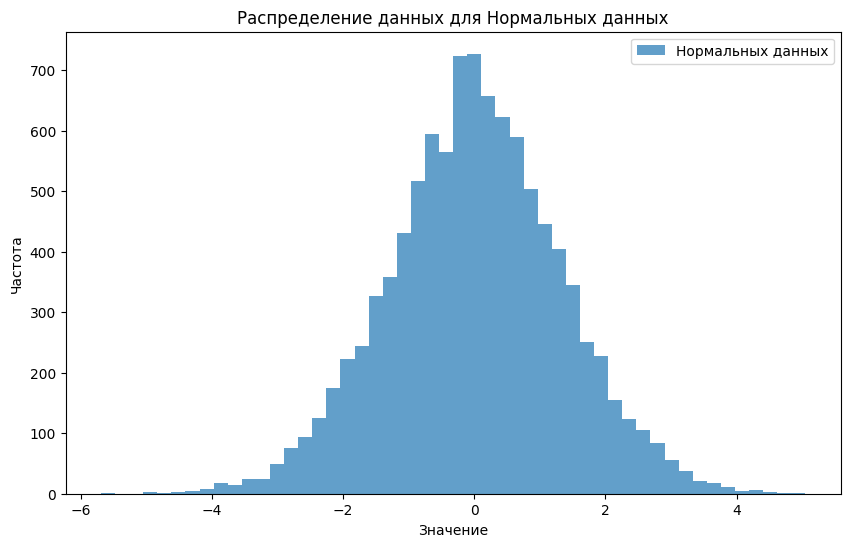

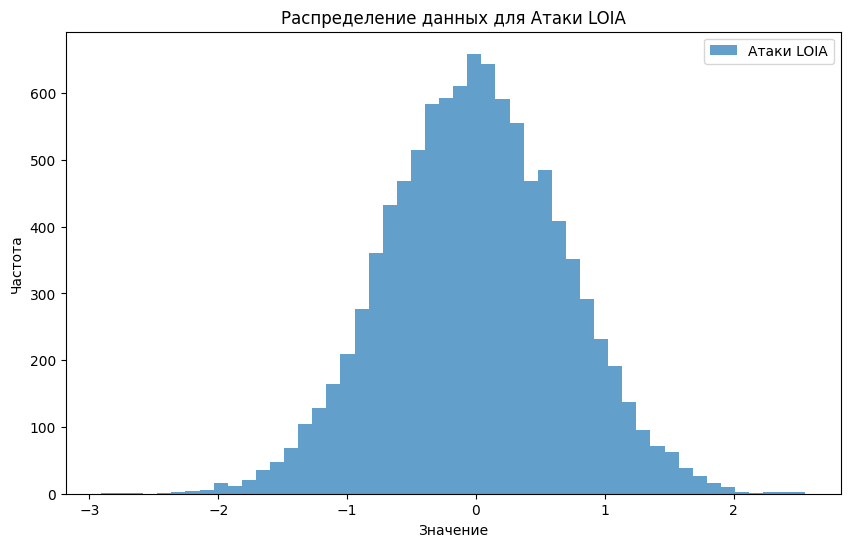

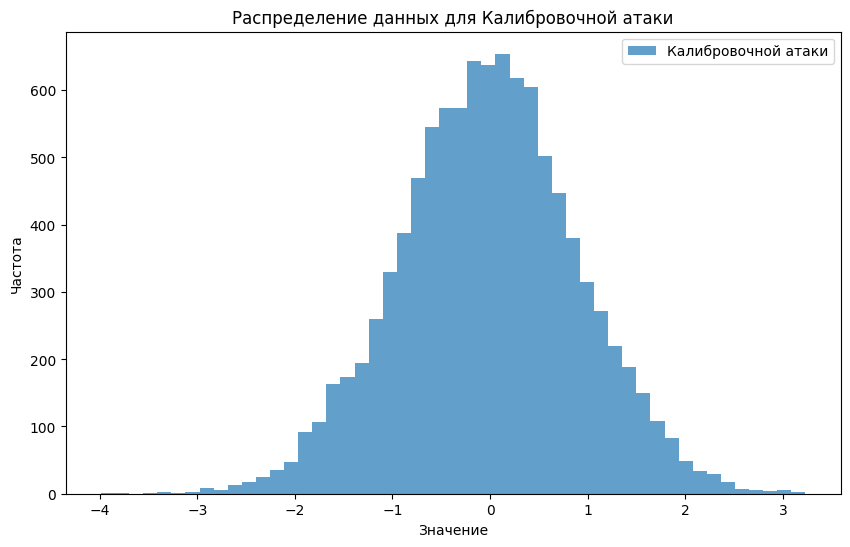

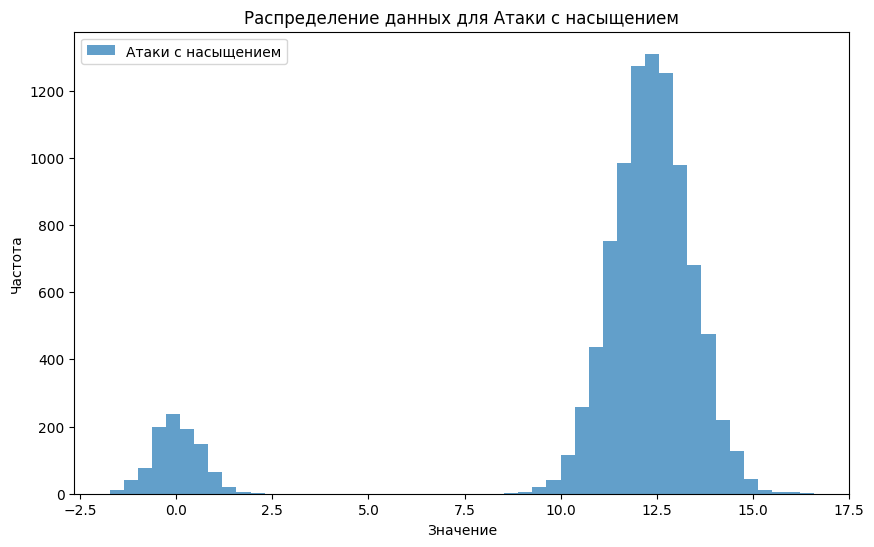

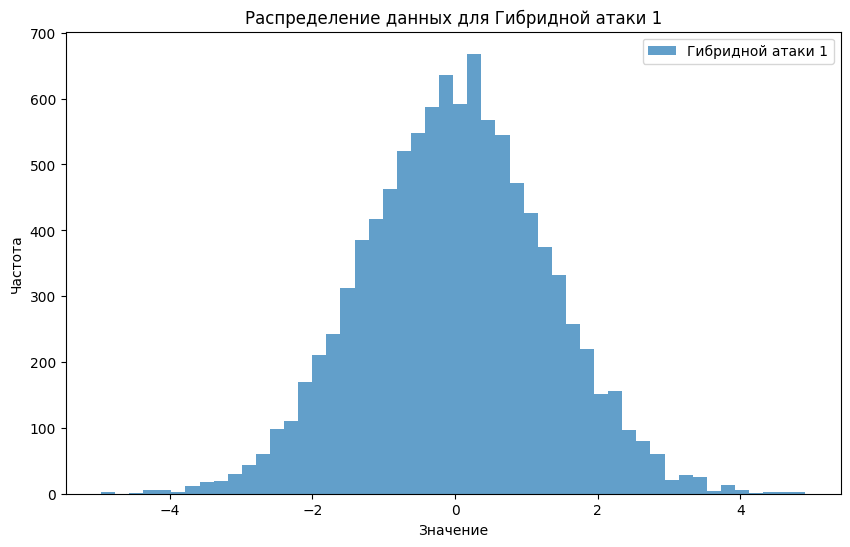

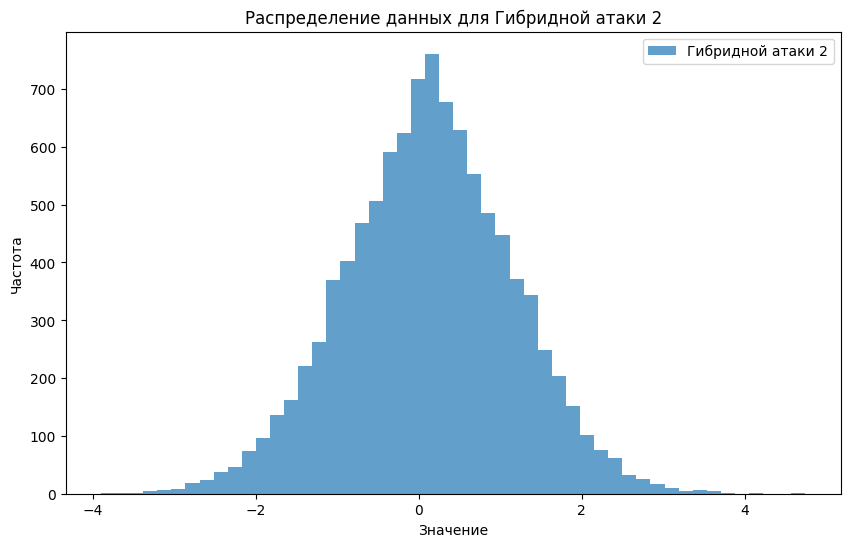

In [ ]:
import matplotlib.pyplot as plt

# Функция для визуализации распределения данных
def plot_data_distribution(data, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, alpha=0.7, label=title)
    plt.title(f"Распределение данных для {title}")
    plt.xlabel("Значение")
    plt.ylabel("Частота")
    plt.legend()
    plt.show()

# Визуализация распределений для каждого типа атаки
plot_data_distribution(data_normal, "Нормальных данных")
plot_data_distribution(data_LOIA, "Атаки LOIA")
plot_data_distribution(data_calib, "Калибровочной атаки")
plot_data_distribution(data_sat, "Атаки с насыщением")
plot_data_distribution(data_hybrid1, "Гибридной атаки 1")
plot_data_distribution(data_hybrid2, "Гибридной атаки 2")


In [ ]:
from sklearn.model_selection import train_test_split

# Создание меток
labels_normal = np.zeros(data_normal.shape[0])
labels_LOIA = np.ones(data_LOIA.shape[0])
labels_calib = np.full(data_calib.shape[0], 2)
labels_sat = np.full(data_sat.shape[0], 3)
labels_hybrid1 = np.full(data_hybrid1.shape[0], 4)
labels_hybrid2 = np.full(data_hybrid2.shape[0], 5)

# Объединение данных
data_combined = np.concatenate([data_normal, data_LOIA, data_calib, data_sat, data_hybrid1, data_hybrid2])
labels_combined = np.concatenate([labels_normal, labels_LOIA, labels_calib, labels_sat, labels_hybrid1, labels_hybrid2])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_combined, labels_combined, test_size=0.2, random_state=42)

# Визуализация размеров выборок
print(f"Размер обучающей выборки: {X_train.shape[0]}, размер тестовой выборки: {X_test.shape[0]}")


Размер обучающей выборки: 48000, размер тестовой выборки: 12000


In [ ]:
%pip install tensorflow


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Перекодировка меток в one-hot вектора
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Определение модели нейронной сети
model = Sequential([
    Dense(64, input_shape=(1,), activation='tanh'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение модели
history = model.fit(
    X_train, y_train_one_hot,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Точность на тестовых данных: {test_accuracy}")


Epoch 1/500
300/300 [==============================] - 1s 3ms/step - loss: 1.5698 - accuracy: 0.2766 - val_loss: 1.4855 - val_accuracy: 0.3001
Epoch 2/500
300/300 [==============================] - 1s 2ms/step - loss: 1.4869 - accuracy: 0.3086 - val_loss: 1.4583 - val_accuracy: 0.2904
Epoch 3/500
300/300 [==============================] - 1s 2ms/step - loss: 1.4674 - accuracy: 0.3143 - val_loss: 1.4482 - val_accuracy: 0.3067
Epoch 4/500
300/300 [==============================] - 1s 2ms/step - loss: 1.4556 - accuracy: 0.3164 - val_loss: 1.4442 - val_accuracy: 0.3132
Epoch 5/500
300/300 [==============================] - 1s 2ms/step - loss: 1.4499 - accuracy: 0.3179 - val_loss: 1.4422 - val_accuracy: 0.3183
Epoch 6/500
300/300 [==============================] - 1s 3ms/step - loss: 1.4489 - accuracy: 0.3164 - val_loss: 1.4409 - val_accuracy: 0.3106
Epoch 7/500
300/300 [==============================] - 1s 3ms/step - loss: 1.4451 - accuracy: 0.3192 - val_loss: 1.4402 - val_accuracy: 0.3141

KeyboardInterrupt: 